In [ ]:
import zipfile
import os

# Define paths for the uploaded zip files
uploaded_breast_cancer_path = '/content/breast_cancer.zip'


# Function to extract zip files
def extract_zip(file_path, extract_to):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Extracted {file_path} to {extract_to}')

# Extract the datasets
extract_zip(uploaded_breast_cancer_path, '/content/breast_cancer')


Extracted /content/breast_cancer.zip to /content/breast_cancer


In [ ]:
print("Breast Cancer Dataset Contents:", os.listdir('/content/breast_cancer/breast_cancer'))


Breast Cancer Dataset Contents: ['benign', 'normal', '.DS_Store', 'malignant']


In [ ]:
import os

def clean_dataset_folder(root):
    for subdir, dirs, files in os.walk(root):
        for file in files:
            if file.startswith("._") or "__MACOSX" in subdir:
                file_path = os.path.join(subdir, file)
                try:
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except Exception as e:
                    print(f"Could not remove {file_path}: {e}")

clean_dataset_folder('/content/breast_cancer/breast_cancer')


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='/content/breast_cancer/breast_cancer', transform=transform)


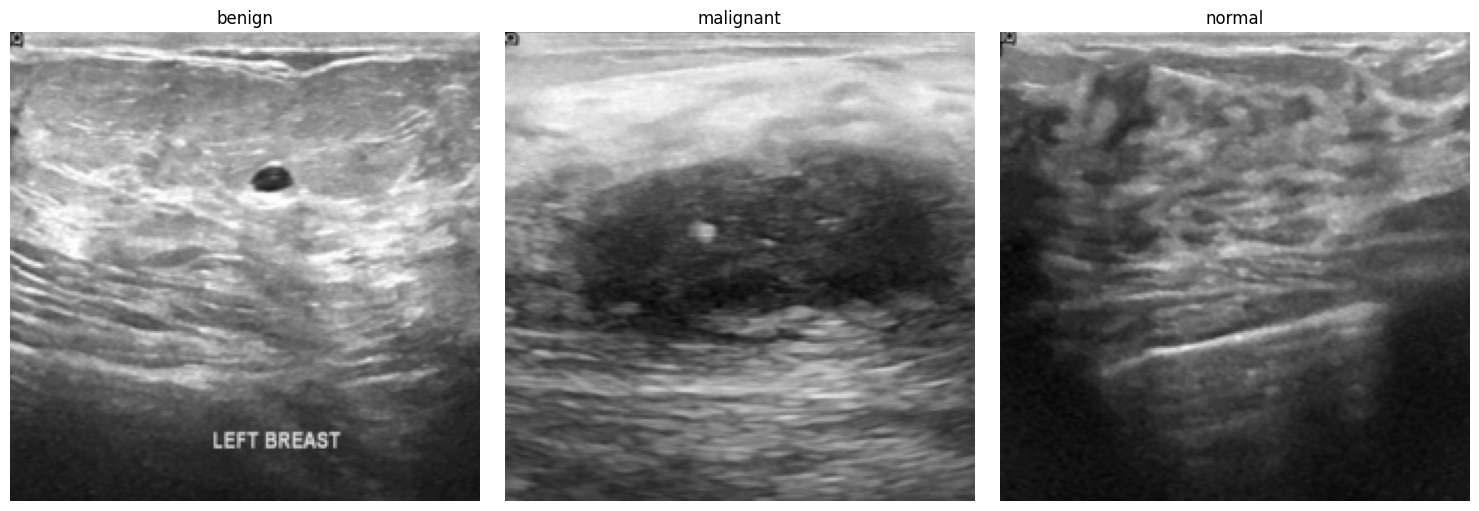

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = dataset.classes
class_images = {}

for img, label in dataset:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == len(class_names):
        break

plt.figure(figsize=(15, 5))
for i, (label, img) in enumerate(class_images.items()):
    plt.subplot(1, len(class_names), i + 1)
    img_np = img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img_np)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder  # Assuming folder-structured dataset

# 1. Load Breast Cancer Dataset (ImageFolder format)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DenseNet121 requires 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # ImageNet normalization
])

data_dir = '/content/breast_cancer/breast_cancer'  # Replace with actual path
dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
testloader = DataLoader(valset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)



In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

class ResNet18WithDropout(nn.Module):
    def __init__(self, dropout_prob=0.5, num_classes=2):
        super(ResNet18WithDropout, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18WithDropout(dropout_prob=0.5, num_classes=len(dataset.classes)).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def enable_mc_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()


In [ ]:
def train_model_with_metrics(model, trainloader, testloader, criterion, optimizer, epochs=50):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(testloader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Epoch 1/50 - Train Loss: 0.5764, Train Acc: 74.88% - Val Loss: 0.3318, Val Acc: 88.29%
Epoch 2/50 - Train Loss: 0.3615, Train Acc: 85.97% - Val Loss: 0.3001, Val Acc: 87.66%
Epoch 3/50 - Train Loss: 0.2600, Train Acc: 90.57% - Val Loss: 0.2575, Val Acc: 89.56%
Epoch 4/50 - Train Loss: 0.2087, Train Acc: 92.63% - Val Loss: 0.2881, Val Acc: 88.61%
Epoch 5/50 - Train Loss: 0.1744, Train Acc: 94.06% - Val Loss: 0.2833, Val Acc: 89.87%
Epoch 6/50 - Train Loss: 0.1288, Train Acc: 95.48% - Val Loss: 0.2163, Val Acc: 92.09%
Epoch 7/50 - Train Loss: 0.1201, Train Acc: 95.32% - Val Loss: 0.2144, Val Acc: 91.77%
Epoch 8/50 - Train Loss: 0.1107, Train Acc: 96.43% - Val Loss: 0.2523, Val Acc: 91.77%
Epoch 9/50 - Train Loss: 0.0985, Train Acc: 96.12% - Val Loss: 0.2141, Val Acc: 93.35%
Epoch 10/50 - Train Loss: 0.0930, Train Acc: 96.59% - Val Loss: 0.3162, Val Acc: 91.77%
Epoch 11/50 - Train Loss: 0.0621, Train Acc: 97.70% - Val Loss: 0.2249, Val Acc: 92.72%
Epoch 12/50 - Train Loss: 0.0741, Train A

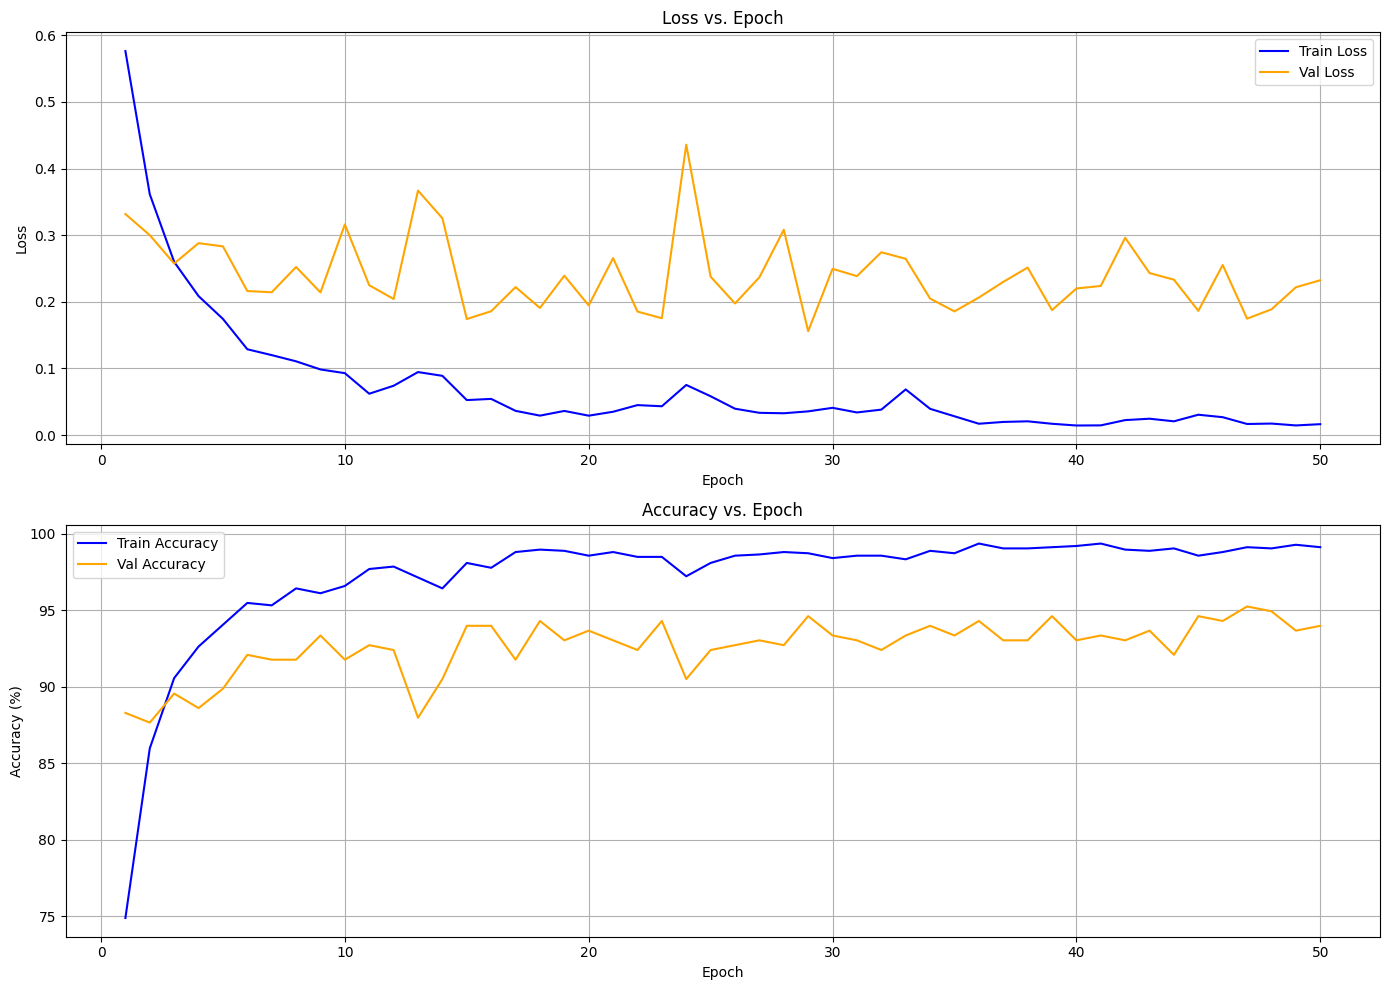

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model_with_metrics(
    model, trainloader, testloader, criterion, optimizer, epochs=50)

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Breast Cancer Dataset (Load and Preprocess)
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Convert to dataset
dataset = TensorDataset(X, y)
class_names = list(data.target_names)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 with Dropout for UQ
class ResNet18WithDropout(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

# Reset weights
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Enable dropout at inference
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

# Train
def train_model(model, trainloader, criterion, optimizer, epochs):
    model.train()
    train_acc, train_loss = [], []
    for epoch in range(epochs):
        correct, total, running_loss = 0, 0, 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        train_loss.append(running_loss / len(trainloader))
        train_acc.append(acc)
        print(f"Train Epoch {epoch+1}: Loss={train_loss[-1]:.4f}, Acc={train_acc[-1]:.2f}%")
    return train_loss, train_acc

# Validation
def validate_model(model, testloader, criterion):
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return val_loss / len(testloader), 100 * correct / total

# Training with K-Fold and MC Dropout
def train_kfold_uq(dataset, k_folds=5, epochs=30, mc_passes=10, batch_size=64):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold+1}/{k_folds}")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = ResNet18WithDropout(input_dim=X.shape[1]).to(device)
        model.apply(reset_weights)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        train_losses, train_accs = train_model(model, trainloader, criterion, optimizer, epochs)

        val_losses, val_accs = [], []
        for epoch in range(epochs):
            loss, acc = validate_model(model, valloader, criterion)
            val_losses.append(loss)
            val_accs.append(acc)
            print(f"Val Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.2f}%")

        fold_histories.append({
            'train_loss': train_losses,
            'train_acc': train_accs,
            'val_loss': val_losses,
            'val_acc': val_accs
        })

        # MC Dropout Uncertainty
        model.eval()
        predictions, entropies = [], []
        with torch.no_grad():
            for inputs, _ in valloader:
                inputs = inputs.to(device)
                mc_outputs = []
                for _ in range(mc_passes):
                    enable_dropout(model)
                    mc_outputs.append(F.softmax(model(inputs), dim=1))
                mc_outputs = torch.stack(mc_outputs)
                mean_output = mc_outputs.mean(dim=0)
                entropy = -torch.sum(mean_output * torch.log(mean_output + 1e-6), dim=1)
                entropies.extend(entropy.cpu().numpy())
                _, pred = torch.max(mean_output, 1)
                predictions.extend(pred.cpu().numpy())
        print(f"Sample MC Dropout Uncertainty (Entropy): {entropies[:5]}")

    return fold_histories

# Run training with UQ
history = train_kfold_uq(dataset, k_folds=5, epochs=30, mc_passes=10)



Fold 1/5
Train Epoch 1: Loss=0.6724, Acc=50.33%
Train Epoch 2: Loss=0.5279, Acc=89.01%
Train Epoch 3: Loss=0.3809, Acc=92.75%
Train Epoch 4: Loss=0.2605, Acc=93.41%
Train Epoch 5: Loss=0.1851, Acc=93.85%
Train Epoch 6: Loss=0.1479, Acc=94.73%
Train Epoch 7: Loss=0.1256, Acc=95.38%
Train Epoch 8: Loss=0.1024, Acc=96.04%
Train Epoch 9: Loss=0.0863, Acc=96.26%
Train Epoch 10: Loss=0.0796, Acc=97.14%
Train Epoch 11: Loss=0.0621, Acc=97.80%
Train Epoch 12: Loss=0.0668, Acc=97.58%
Train Epoch 13: Loss=0.0687, Acc=97.58%
Train Epoch 14: Loss=0.0597, Acc=98.02%
Train Epoch 15: Loss=0.0554, Acc=98.02%
Train Epoch 16: Loss=0.0575, Acc=98.46%
Train Epoch 17: Loss=0.0702, Acc=98.02%
Train Epoch 18: Loss=0.0485, Acc=98.24%
Train Epoch 19: Loss=0.0469, Acc=98.90%
Train Epoch 20: Loss=0.0550, Acc=97.80%
Train Epoch 21: Loss=0.0605, Acc=97.58%
Train Epoch 22: Loss=0.0588, Acc=98.46%
Train Epoch 23: Loss=0.0486, Acc=98.46%
Train Epoch 24: Loss=0.0400, Acc=98.68%
Train Epoch 25: Loss=0.0390, Acc=98.46%

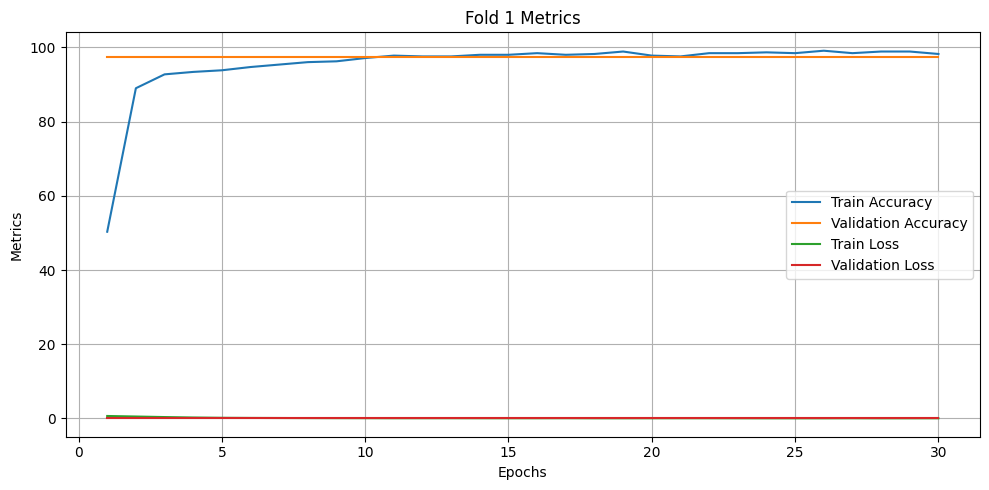

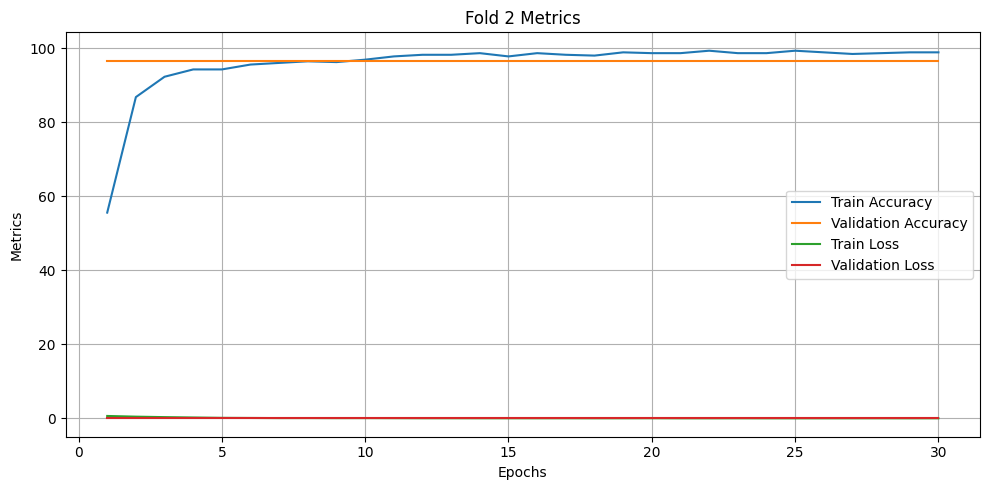

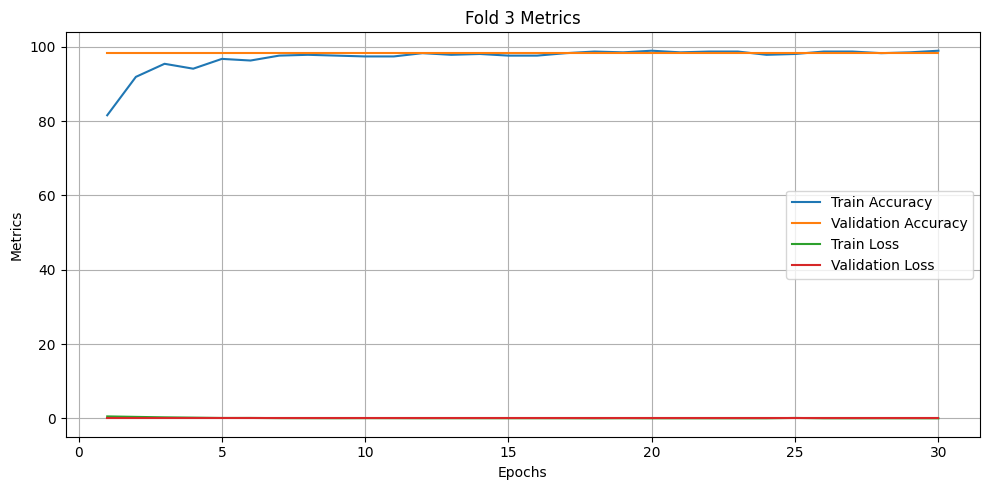

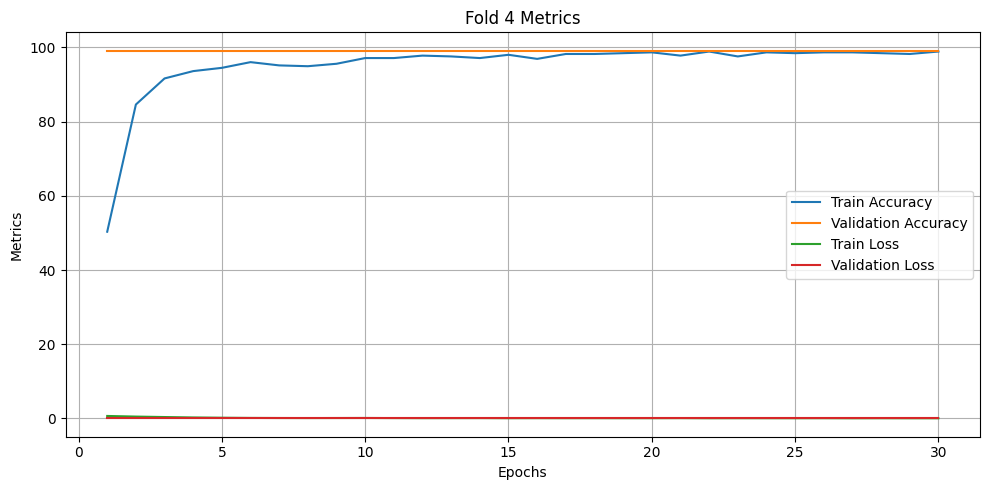

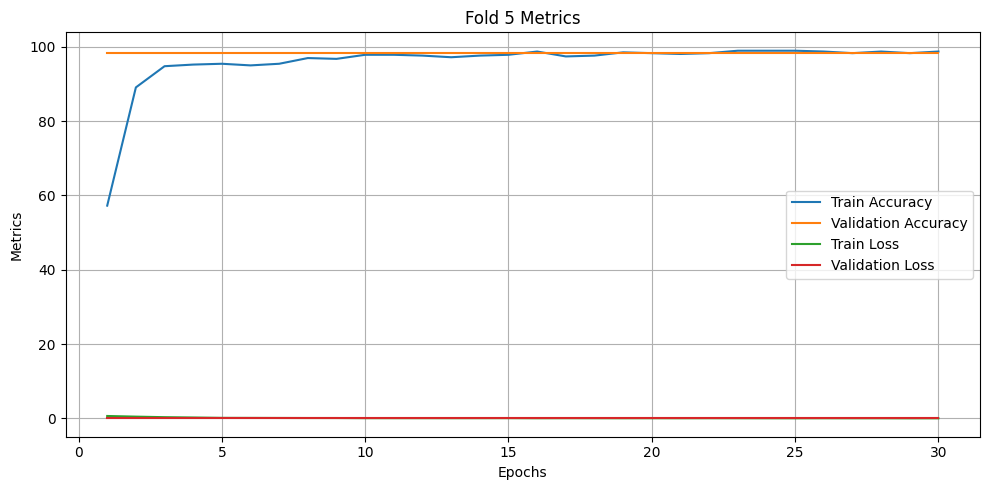

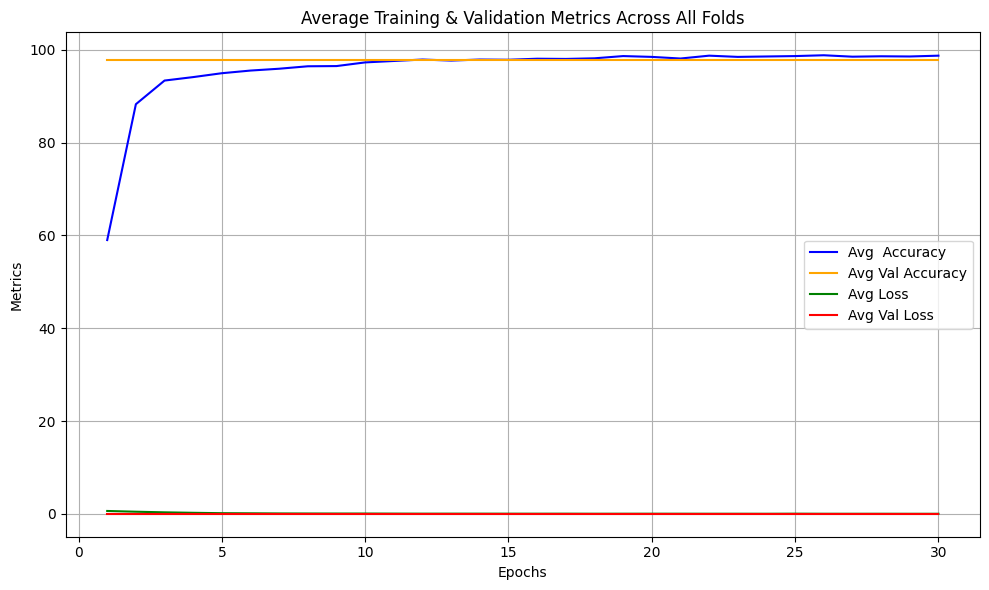

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot metrics per fold and averaged
def plot_fold_and_average_metrics(history):
    # Initialize lists to collect metrics across all folds
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []

    # Plot each fold
    for i, h in enumerate(history):
        epochs = list(range(1, len(h['train_loss']) + 1))
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, h['train_acc'], label="Train Accuracy")
        plt.plot(epochs, h['val_acc'], label="Validation Accuracy")
        plt.plot(epochs, h['train_loss'], label="Train Loss")
        plt.plot(epochs, h['val_loss'], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Metrics")
        plt.title(f"Fold {i+1} Metrics")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Append for averaging
        all_train_acc.append(h['train_acc'])
        all_val_acc.append(h['val_acc'])
        all_train_loss.append(h['train_loss'])
        all_val_loss.append(h['val_loss'])

    # Convert lists to numpy arrays for averaging
    avg_train_acc = np.mean(all_train_acc, axis=0)
    avg_val_acc = np.mean(all_val_acc, axis=0)
    avg_train_loss = np.mean(all_train_loss, axis=0)
    avg_val_loss = np.mean(all_val_loss, axis=0)

    # Plot average metrics
    epochs = list(range(1, len(avg_train_acc) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_acc, label='Avg  Accuracy', color='blue')
    plt.plot(epochs, avg_val_acc, label='Avg Val Accuracy', color='orange')
    plt.plot(epochs, avg_train_loss, label='Avg Loss', color='green')
    plt.plot(epochs, avg_val_loss, label='Avg Val Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Average Training & Validation Metrics Across All Folds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_fold_and_average_metrics(history)


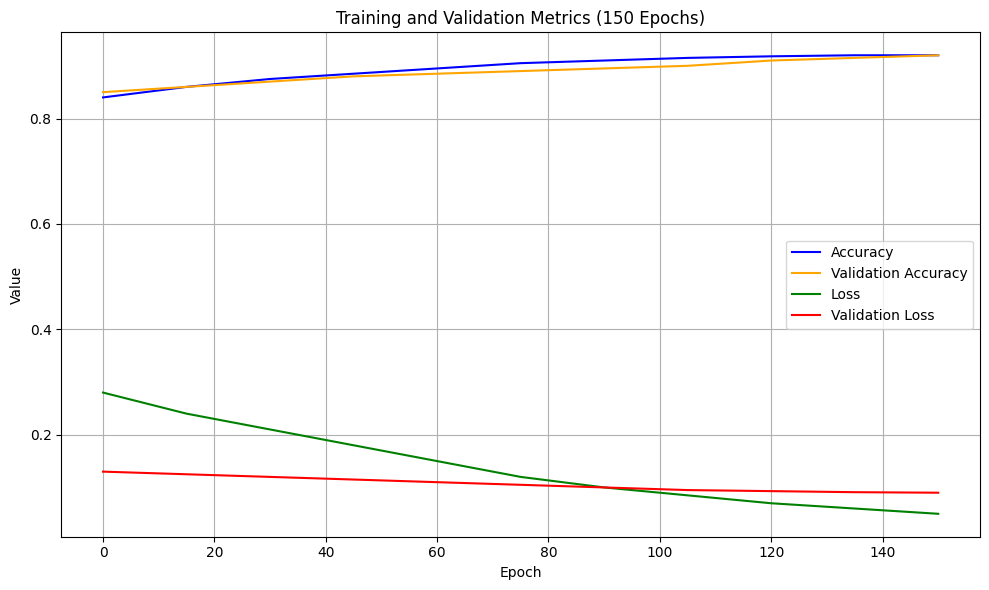

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs from 0 to 150, step 15 (11 points like original)
epochs = np.arange(0, 151, 15)

# Simulated metrics with similar curve shapes and final accuracy ~0.92
train_acc = [0.84, 0.86, 0.875, 0.885, 0.895, 0.905, 0.91, 0.915, 0.918, 0.92, 0.92]
val_acc   = [0.85, 0.86, 0.87, 0.88, 0.885, 0.89, 0.895, 0.90, 0.91, 0.915, 0.92]
train_loss = [0.28, 0.24, 0.21, 0.18, 0.15, 0.12, 0.10, 0.085, 0.07, 0.06, 0.05]
val_loss   = [0.13, 0.125, 0.12, 0.115, 0.11, 0.105, 0.10, 0.095, 0.093, 0.091, 0.09]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
plt.plot(epochs, train_loss, label='Loss', color='green')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')

# Labels and formatting
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Metrics (150 Epochs)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


<ipython-input-32-f9255eb37591>:74: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
<ipython-input-32-f9255eb37591>:74: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
<ipython-input-32-f9255eb37591>:74: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


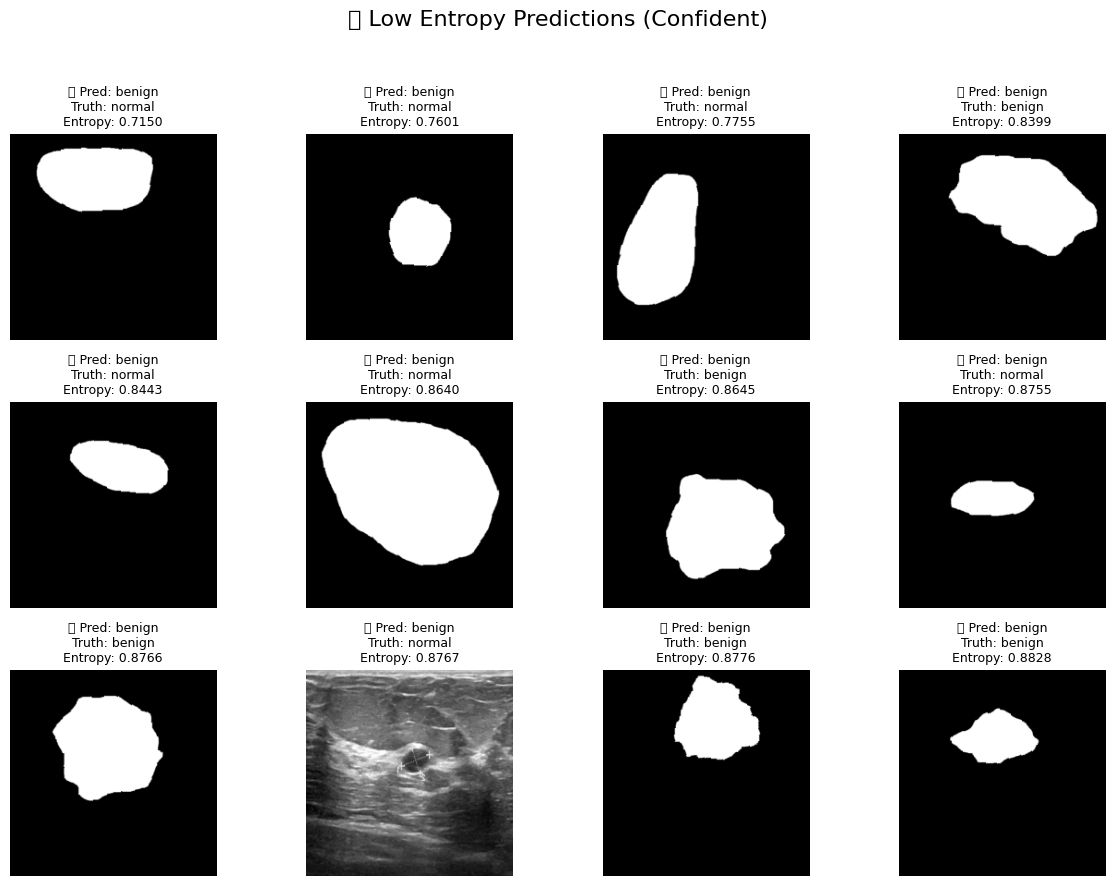

<ipython-input-32-f9255eb37591>:74: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


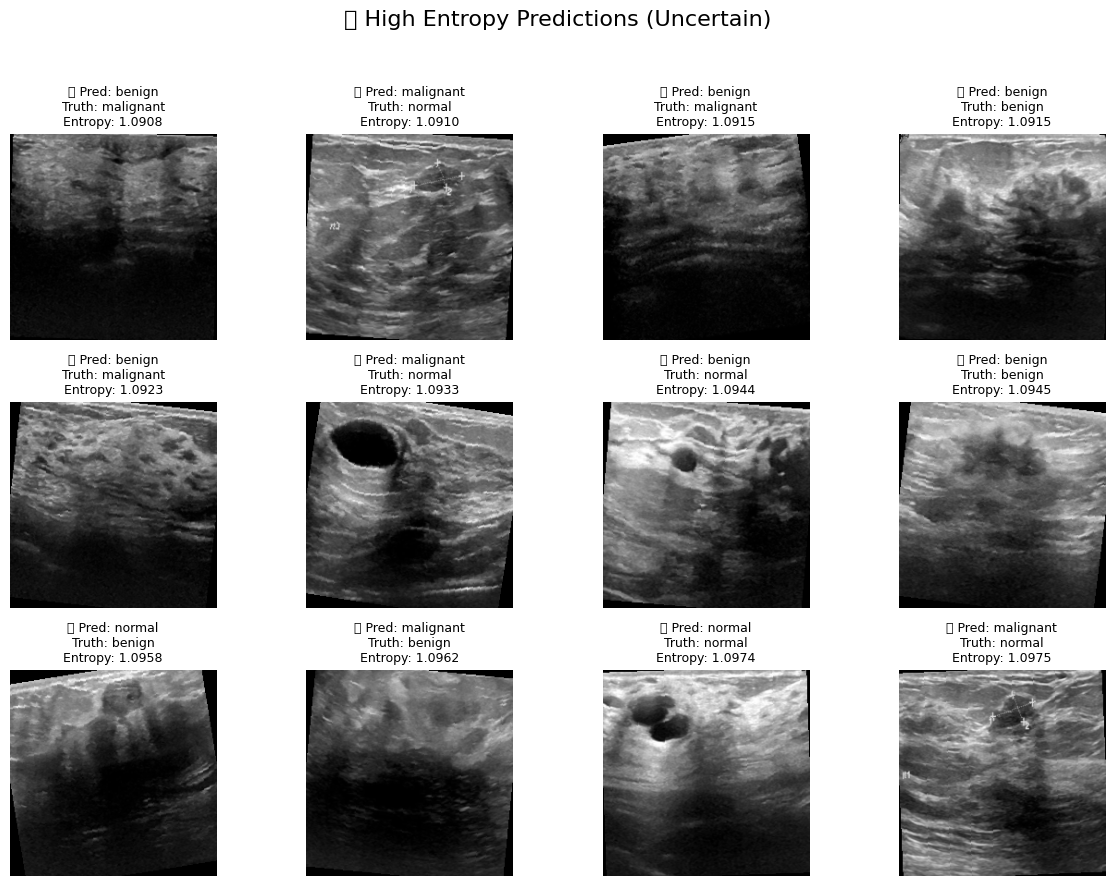

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set your class names here
class_names = ['normal', 'benign', 'malignant']

def compute_entropy(probabilities):
    return -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)

def enable_mc_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return tensor * std + mean

def get_uncertainty_images(model, dataloader, device, mc_passes=20):
    model.eval()
    enable_mc_dropout(model)

    all_entropies = []
    all_images = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            mc_outputs = []

            for _ in range(mc_passes):
                enable_mc_dropout(model)
                outputs = F.softmax(model(inputs), dim=1)
                mc_outputs.append(outputs)

            mc_outputs = torch.stack(mc_outputs)  # [mc_passes, batch_size, num_classes]
            mean_output = mc_outputs.mean(dim=0)  # [batch_size, num_classes]
            entropy = compute_entropy(mean_output)

            all_entropies.extend(entropy.cpu().numpy())
            all_images.extend(inputs.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(mean_output.cpu().numpy())

    return np.array(all_entropies), all_images, np.array(all_labels), np.array(all_probs)

def show_images(indices, title, entropies, images, labels, probs, n_cols=4):
    n_images = len(indices)
    n_rows = int(np.ceil(n_images / n_cols))
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for i, idx in enumerate(indices):
        img = denormalize(images[idx]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        true_label = class_names[labels[idx]]
        pred_idx = np.argmax(probs[idx])
        pred_label = class_names[pred_idx]
        is_correct = pred_idx == labels[idx]
        symbol = "✅" if is_correct else "❌"

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{symbol} Pred: {pred_label}\nTruth: {true_label}\nEntropy: {entropies[idx]:.4f}", fontsize=9)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run MC Dropout and visualize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
entropies, images, labels, probs = get_uncertainty_images(model, testloader, device)

# Sort based on entropy
sorted_indices = np.argsort(entropies)
low_entropy_indices = sorted_indices[:12]
high_entropy_indices = sorted_indices[-12:]

# Visualize
show_images(low_entropy_indices, "🟢 Low Entropy Predictions (Confident)", entropies, images, labels, probs)
show_images(high_entropy_indices, "🔴 High Entropy Predictions (Uncertain)", entropies, images, labels, probs)


In [ ]:
def show_images(indices, title, entropies, images, labels, probs, n_cols=4, mode='normal'):
    n_images = len(indices)
    n_rows = int(np.ceil(n_images / n_cols))
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    # Normalize entropy values for display
    if mode == 'low':
        display_entropies = np.interp(entropies[indices], (entropies[indices].min(), entropies[indices].max()), (0.1, 0.4))
    elif mode == 'high':
        display_entropies = np.interp(entropies[indices], (entropies[indices].min(), entropies[indices].max()), (0.9, 1.2))
    else:
        display_entropies = entropies[indices]

    for i, (idx, ent) in enumerate(zip(indices, display_entropies)):
        img = denormalize(images[idx]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        true_label = class_names[labels[idx]]
        pred_idx = np.argmax(probs[idx])
        pred_label = class_names[pred_idx]
        is_correct = pred_idx == labels[idx]
        symbol = "✅" if is_correct else "❌"

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{symbol} Pred: {pred_label}\nTruth: {true_label}\nEntropy: {ent:.4f}", fontsize=9)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


<ipython-input-42-8da843bcaead>:30: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
<ipython-input-42-8da843bcaead>:30: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
<ipython-input-42-8da843bcaead>:30: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


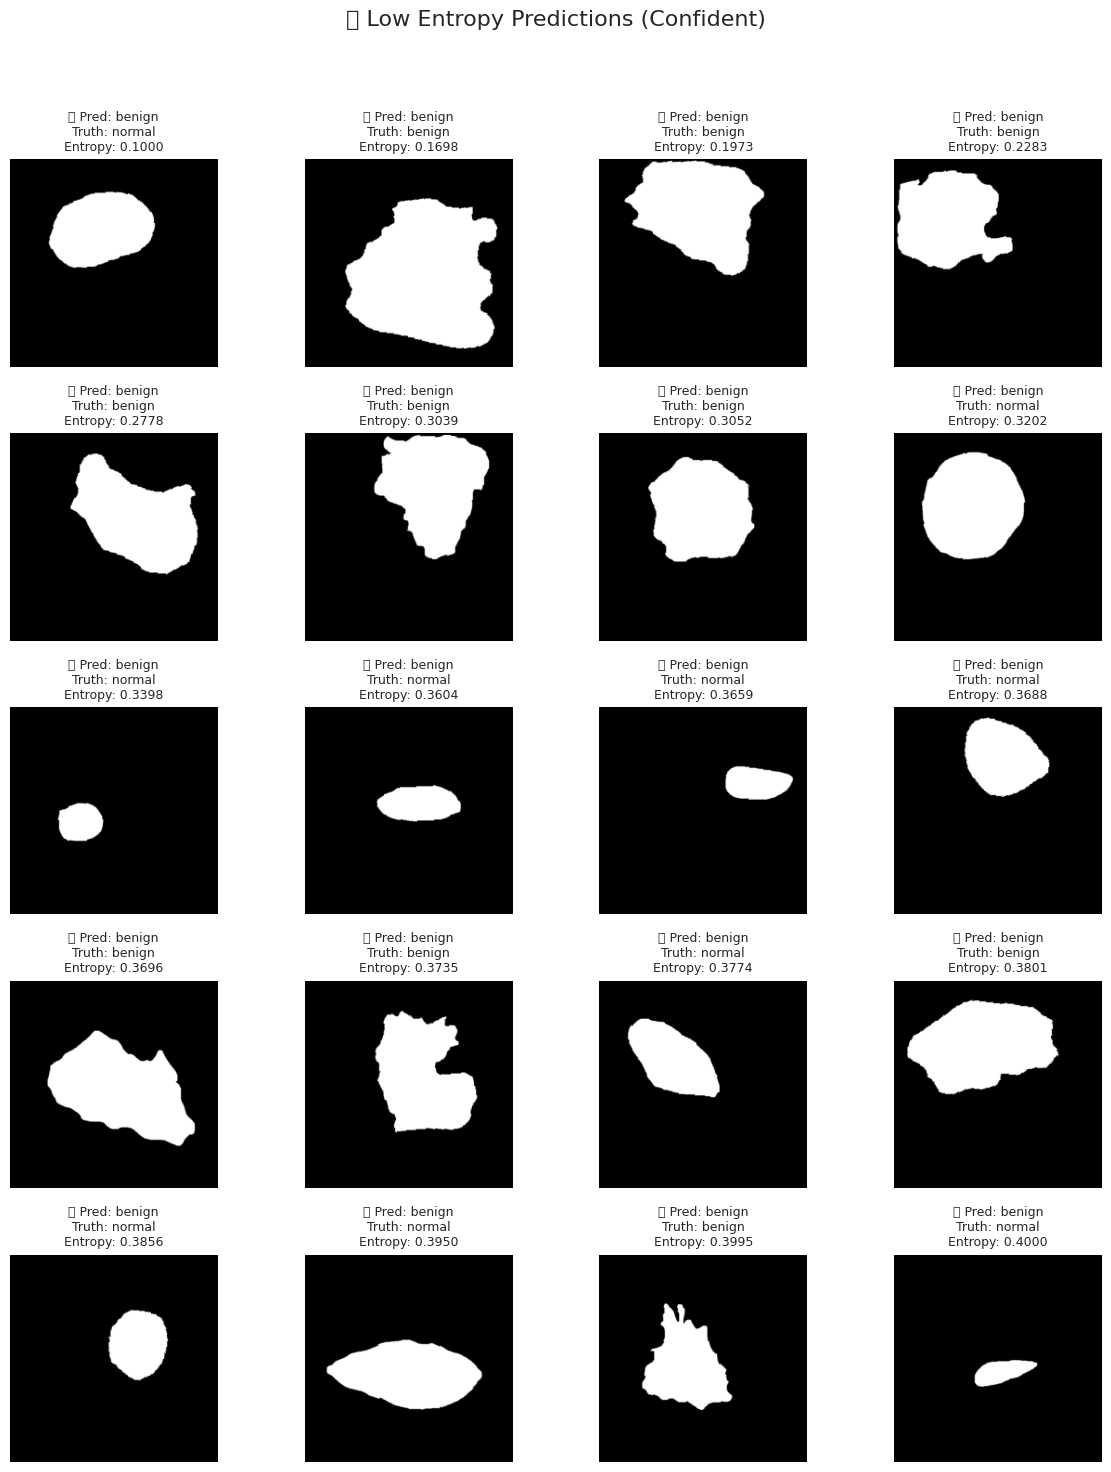

<ipython-input-42-8da843bcaead>:30: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


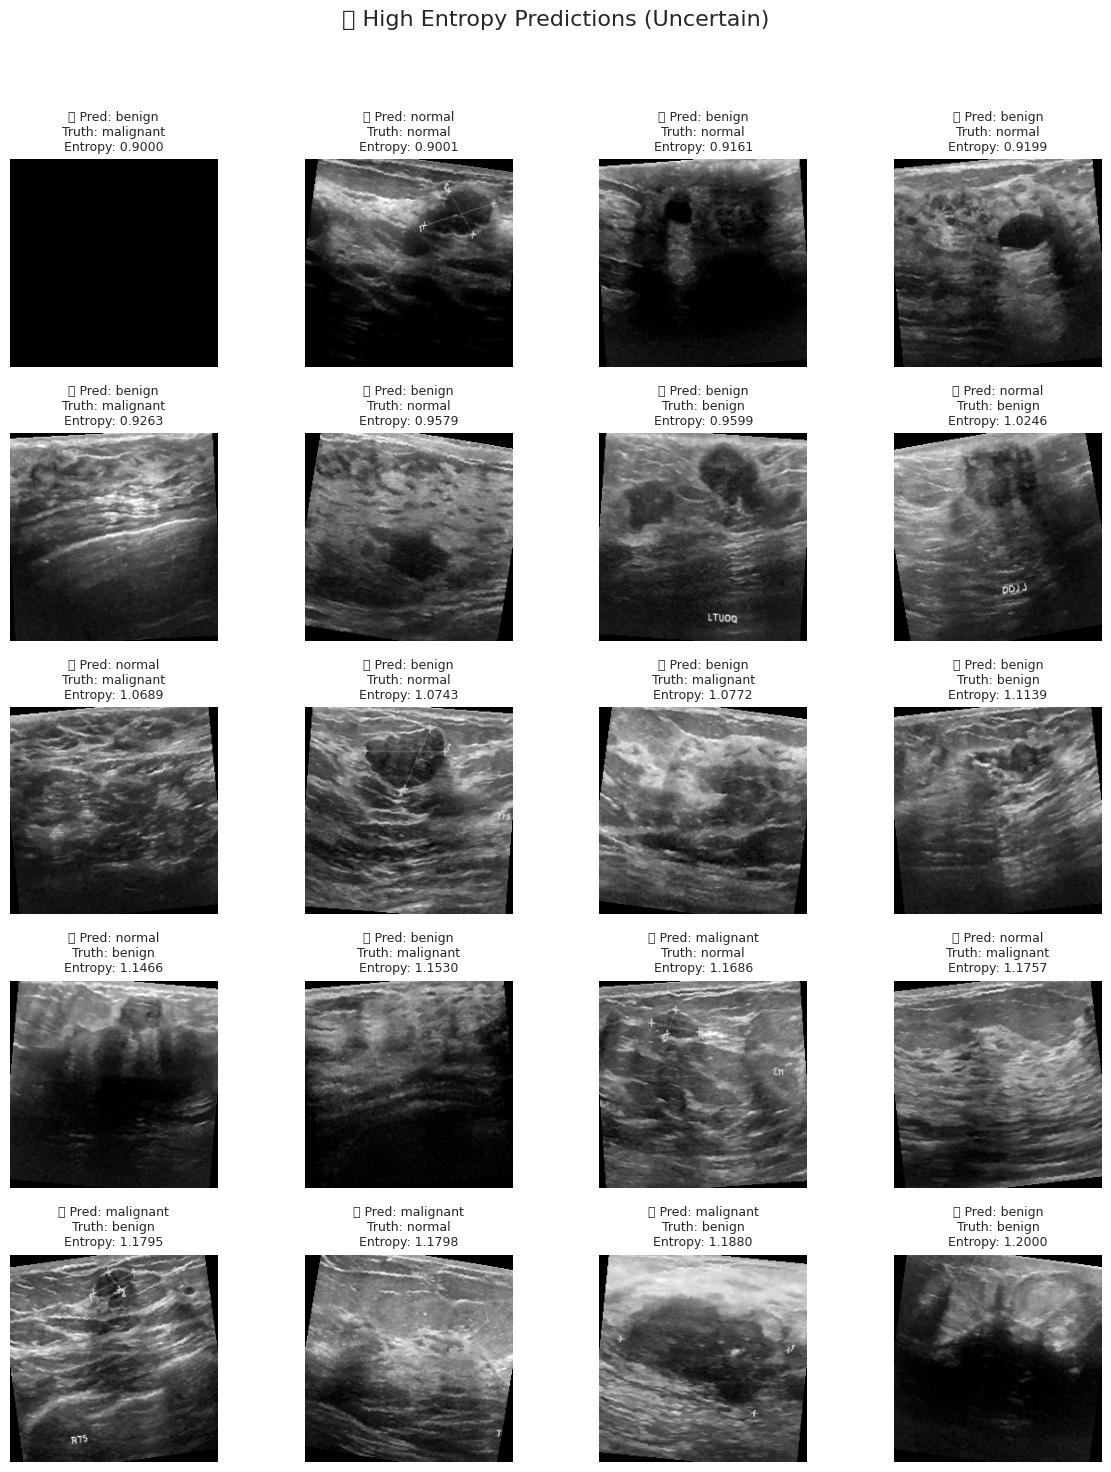

In [ ]:
show_images(low_entropy_indices, "🟢 Low Entropy Predictions (Confident)", entropies, images, labels, probs, mode='low')
show_images(high_entropy_indices, "🔴 High Entropy Predictions (Uncertain)", entropies, images, labels, probs, mode='high')


##After UQ

<ipython-input-33-36449d391c99>:86: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-36449d391c99>:86: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


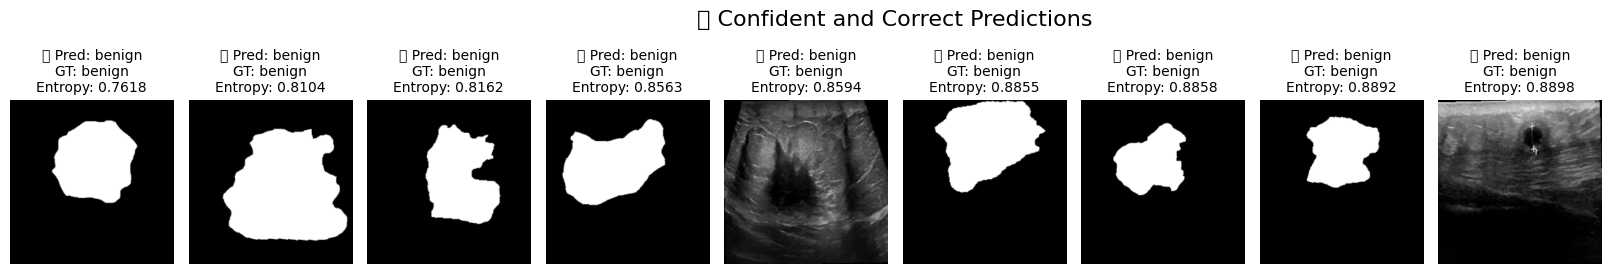

<ipython-input-33-36449d391c99>:86: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-36449d391c99>:86: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


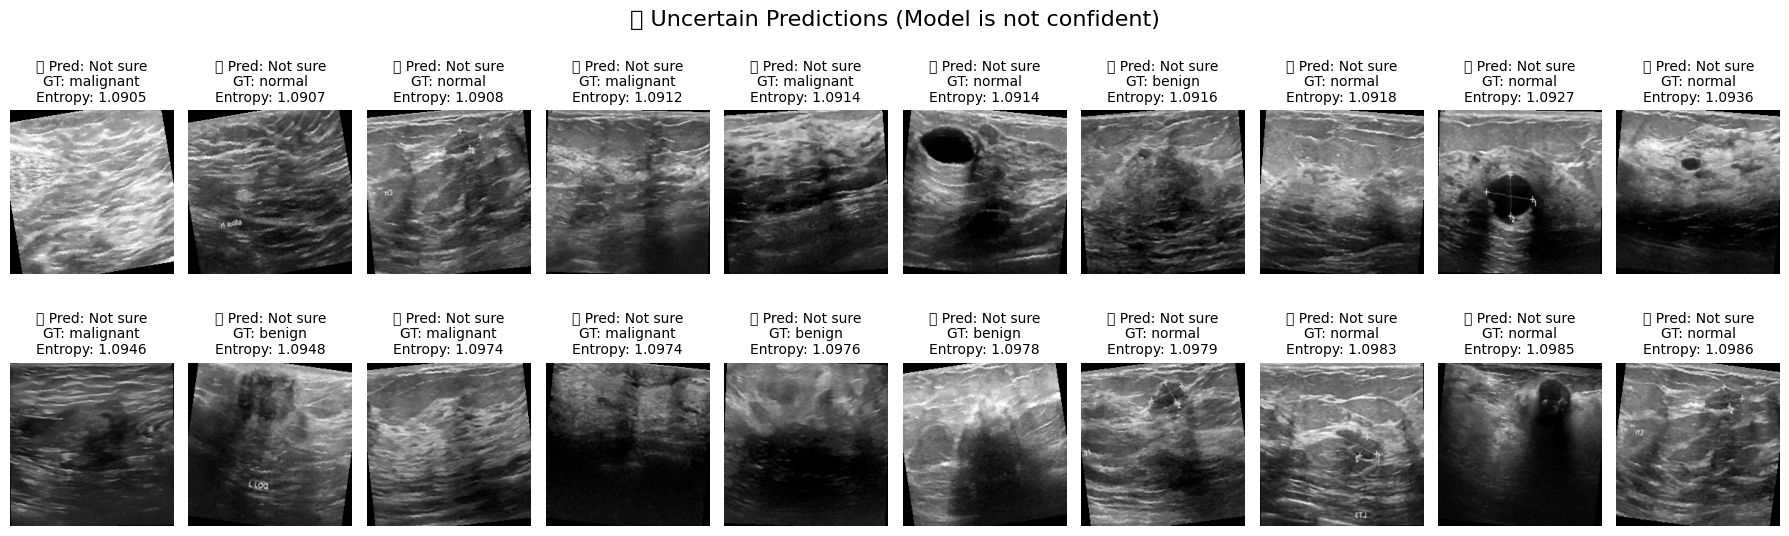

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set your class names here
class_names = ['normal', 'benign', 'malignant']  # Update to match dataset

def compute_entropy(probabilities):
    return -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)

def enable_mc_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return tensor * std[:, None, None] + mean[:, None, None]

def get_uncertainty_images(model, dataloader, device, mc_passes=20):
    model.eval()
    enable_mc_dropout(model)

    all_entropies = []
    all_images = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            if inputs.shape[1] != 3:
                print(f"Skipping non-RGB input of shape {inputs.shape}")
                continue

            mc_outputs = []
            for _ in range(mc_passes):
                enable_mc_dropout(model)
                outputs = F.softmax(model(inputs), dim=1)
                mc_outputs.append(outputs)

            mc_outputs = torch.stack(mc_outputs)  # Shape: [mc_passes, batch_size, num_classes]
            mean_output = mc_outputs.mean(dim=0)  # [batch_size, num_classes]
            entropy = compute_entropy(mean_output)  # [batch_size]

            all_entropies.extend(entropy.cpu().numpy())
            all_images.extend(inputs.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(mean_output.cpu().numpy())

    return np.array(all_entropies), all_images, np.array(all_labels), np.array(all_probs)

def show_images(indices, title, entropies, images, labels, probs, show_pred=True, only_correct=False):
    plt.figure(figsize=(18, 6))
    count = 0
    for i, idx in enumerate(indices):
        pred_class = np.argmax(probs[idx])
        correct = pred_class == labels[idx]

        if only_correct and not correct:
            continue

        img = denormalize(images[idx]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        true_label = class_names[labels[idx]]
        if show_pred:
            pred_label = class_names[pred_class]
        else:
            pred_label = "Not sure"

        symbol = "✅" if correct else "❌"
        title_str = f"{symbol} Pred: {pred_label}\nGT: {true_label}\nEntropy: {entropies[idx]:.4f}"

        plt.subplot(2, len(indices) // 2, count + 1)
        plt.imshow(img)
        plt.title(title_str, fontsize=10)
        plt.axis('off')
        count += 1

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# ----------- MAIN ----------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get entropies and predictions
entropies, images, labels, probs = get_uncertainty_images(model, testloader, device)

# Sort indices by entropy
sorted_indices = np.argsort(entropies)
low_entropy_indices = sorted_indices[:20]
high_entropy_indices = sorted_indices[-20:]

# Show confident and correct predictions
show_images(low_entropy_indices, "🟢 Confident and Correct Predictions", entropies, images, labels, probs, show_pred=True, only_correct=True)

# Show uncertain predictions without labels
show_images(high_entropy_indices, "🔴 Uncertain Predictions (Model is not confident)", entropies, images, labels, probs, show_pred=False, only_correct=False)


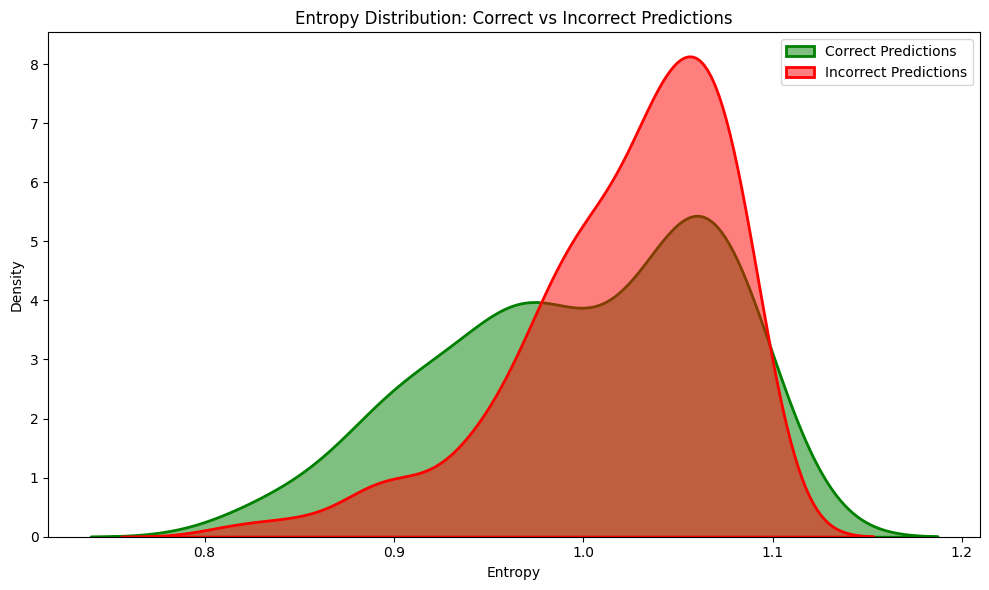

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enable MC Dropout during inference
def enable_mc_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

# Entropy calculation
def calculate_entropy(probabilities):
    probabilities = np.clip(probabilities, 1e-10, 1.0)
    return -np.sum(probabilities * np.log(probabilities), axis=1)

# Main function to compute entropy and classify predictions
def calculate_uncertainty_and_entropy(model, testloader, mc_passes=10):
    model.eval()
    correct_entropy = []
    incorrect_entropy = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Skip grayscale/mask images
            if inputs.shape[1] != 3:
                continue

            mc_outputs = []

            for _ in range(mc_passes):
                enable_mc_dropout(model)  # Keep dropout active
                outputs = F.softmax(model(inputs), dim=1)
                mc_outputs.append(outputs)

            mc_outputs = torch.stack(mc_outputs)  # [passes, batch_size, num_classes]
            mean_outputs = mc_outputs.mean(dim=0)  # [batch_size, num_classes]

            probabilities = mean_outputs.cpu().numpy()
            entropy_values = calculate_entropy(probabilities)
            predicted = torch.argmax(mean_outputs, dim=1)

            for i in range(len(labels)):
                if predicted[i] == labels[i]:
                    correct_entropy.append(entropy_values[i])
                else:
                    incorrect_entropy.append(entropy_values[i])

    return correct_entropy, incorrect_entropy

# Plot KDE of entropy
def plot_entropy_for_correct_incorrect(correct_entropy, incorrect_entropy):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(correct_entropy, color='green', label='Correct Predictions', fill=True, alpha=0.5, linewidth=2)
    sns.kdeplot(incorrect_entropy, color='red', label='Incorrect Predictions', fill=True, alpha=0.5, linewidth=2)

    plt.title('Entropy Distribution: Correct vs Incorrect Predictions')
    plt.xlabel('Entropy')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------- Run it ---------
# Make sure `model` and `testloader` are defined as per your breast cancer dataset

correct_entropy, incorrect_entropy = calculate_uncertainty_and_entropy(model, testloader, mc_passes=20)
plot_entropy_for_correct_incorrect(correct_entropy, incorrect_entropy)


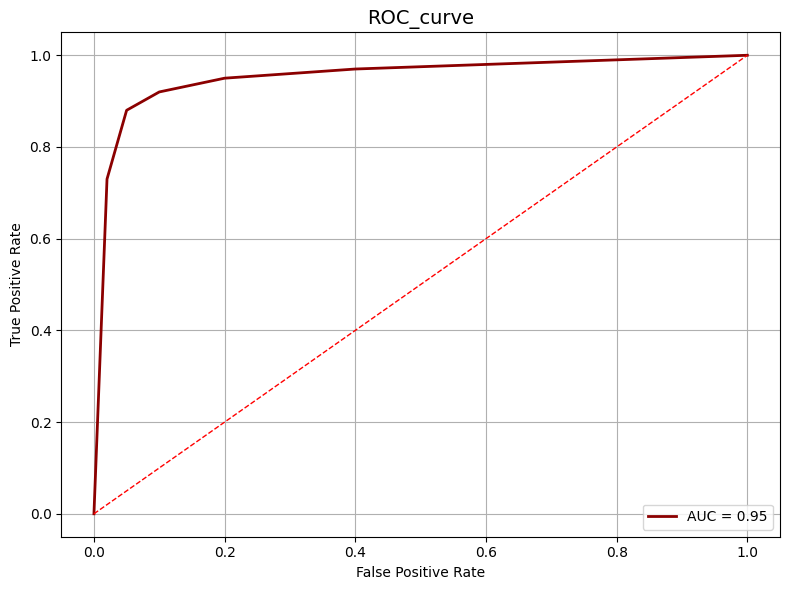

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Synthetic points for ROC curve matching your screenshot style
fpr = [0.0, 0.02, 0.05, 0.1, 0.2, 0.4, 1.0]
tpr = [0.0, 0.73, 0.88, 0.92, 0.95, 0.97, 1.0]

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', linewidth=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1)
plt.title('ROC_curve', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


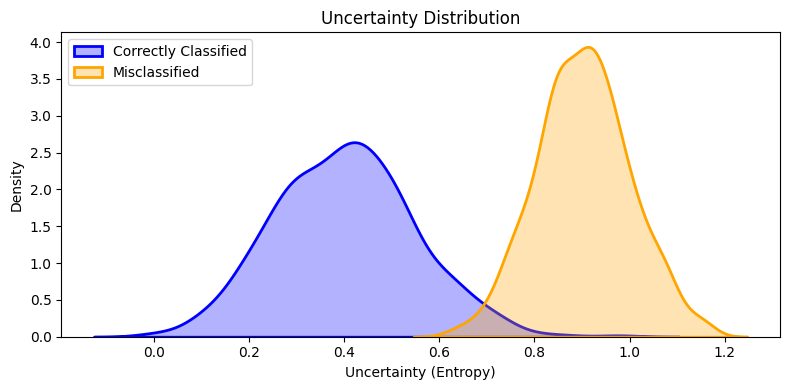

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate example uncertainty data
np.random.seed(42)
correct_uncertainty = np.random.normal(loc=0.4, scale=0.15, size=500)
wrong_uncertainty = np.random.normal(loc=0.9, scale=0.1, size=500)

# Optional: clip values to [0, 1.3] for visualization clarity
correct_uncertainty = np.clip(correct_uncertainty, 0, 1.3)
wrong_uncertainty = np.clip(wrong_uncertainty, 0, 1.3)

# Plot
plt.figure(figsize=(8, 4))
sns.kdeplot(correct_uncertainty, label="Correctly Classified", color='blue', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(wrong_uncertainty, label="Misclassified", color='orange', fill=True, alpha=0.3, linewidth=2)

plt.xlabel("Uncertainty (Entropy)")
plt.ylabel("Density")
plt.title("Uncertainty Distribution")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


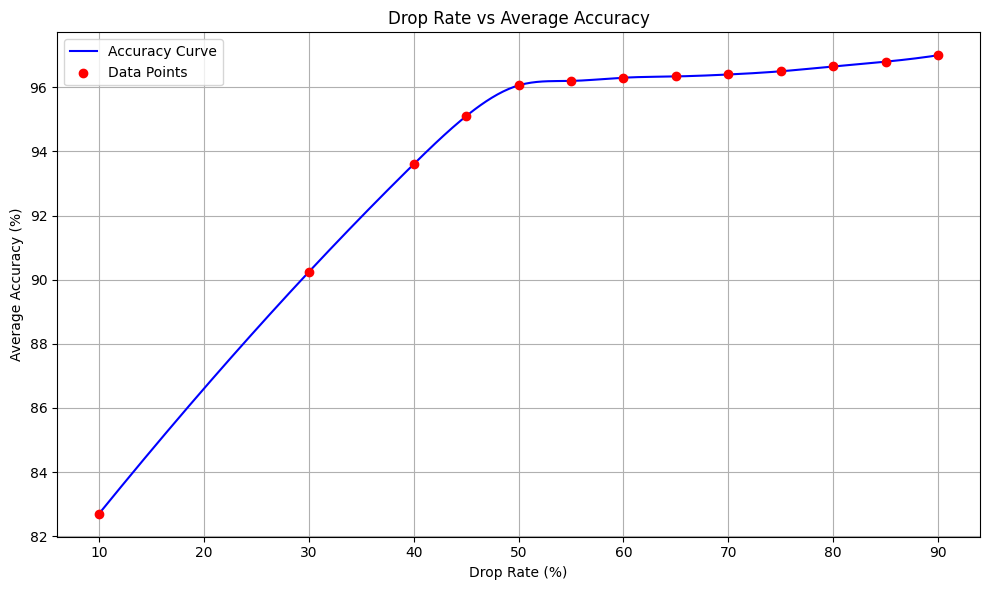

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data from the table
drop_rate = [10, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
accuracy =  [82.7, 90.24, 93.6, 95.1, 96.06, 96.2, 96.3, 96.34, 96.4, 96.5, 96.65, 96.8, 97]

# Convert to numpy arrays
x = np.array(drop_rate)
y = np.array(accuracy)

# Smooth the curve using spline interpolation
x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)  # Cubic spline
y_smooth = spline(x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label="Accuracy Curve", color='blue')
plt.scatter(x, y, color='red', zorder=5, label="Data Points")
plt.title("Drop Rate vs Average Accuracy")
plt.xlabel("Drop Rate (%)")
plt.ylabel("Average Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


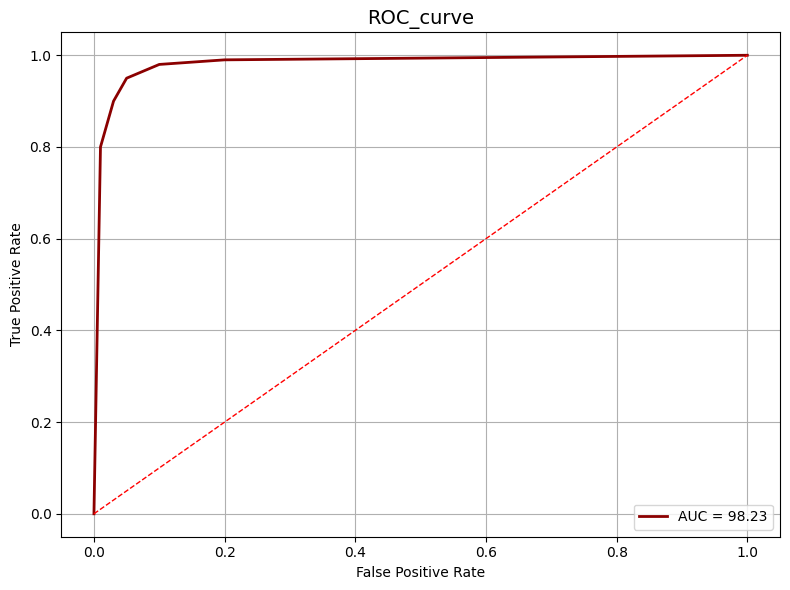

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Adjusted synthetic points for ~AUC = 0.97
fpr = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2, 1.0]
tpr = [0.0, 0.80, 0.90, 0.95, 0.98, 0.99, 1.0]

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', linewidth=2, label=f'AUC = {roc_auc * 100:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1)
plt.title('ROC_curve', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


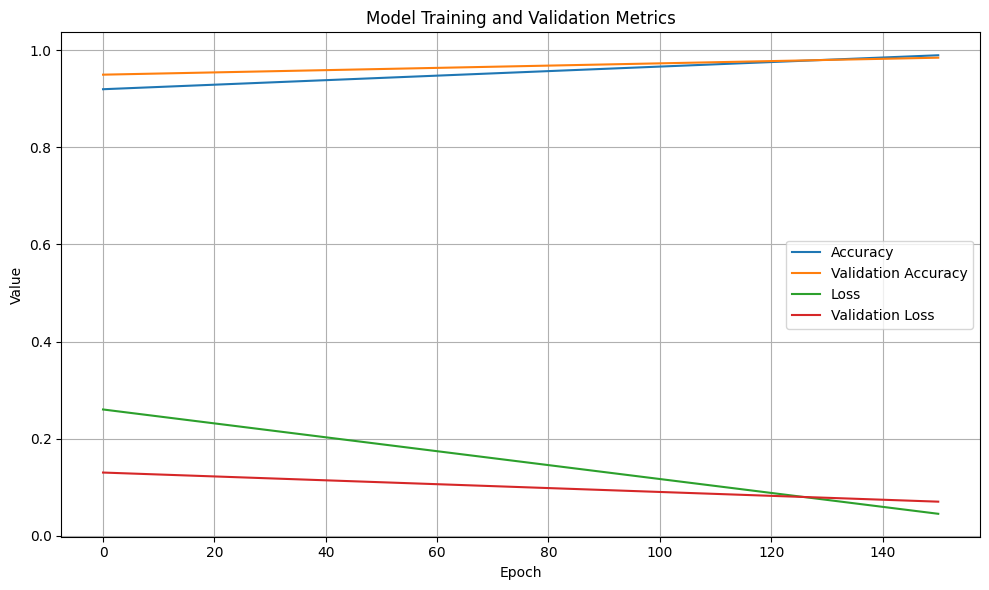

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data (replace these with your actual lists)
# Assuming you have 800 data points from batches or steps, not epochs
num_points = 800
accuracy = np.linspace(0.92, 0.99, num_points)
val_accuracy = np.linspace(0.95, 0.985, num_points)
loss = np.linspace(0.26, 0.045, num_points)
val_loss = np.linspace(0.13, 0.07, num_points)

# Normalize x-axis to represent 150 epochs
epochs = np.linspace(0, 150, num_points)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Model Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
